In [5]:
import numpy as np
import pandas as pd
from scipy import stats
from csv import reader
from random import seed
from random import randrange
from Utils import PriorUtils as pu
from Utils import CorrectnessMetricUtils as cmu
from Utils import ErrorMetricsUtils as emu
import matplotlib.pyplot as plt

# Get CSV file
def get_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        data = reader(file)
        for row in data:
            if not row:
                continue
            dataset.append(row)
    return dataset

# String to float columnwise
def str_to_float_col(dataset, col):
    for row in dataset:
        row[col] = float(row[col].strip())
        
# Split dataset into n folds
def crossval_split(dataset, n_folds):
    split = list()
    dataset_copy = list(dataset)
    fold_dim = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_dim:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        split.append(fold)
    return split

# Divide dataset by class
# dataset contains all the data including labels (y)
# output gives a dictionary with keys being label types and values being all samples corresponding to that label
def class_divider(dataset):
    divided = dict()
    for i in range(len(dataset)):
        row = dataset[i]
        class_type = row[-1]
        if (class_type not in divided):
            divided[class_type] = list()
        divided[class_type].append(row)
    return divided

# Mean, stde and count columnwise
# dataset contains all the data including labels (y)
# output gives mean and standard deviation for each column (feature) except the last (labels)
def dataset_info(dataset):
    info = [(np.mean(col), np.std(col), len(col)) for col in zip(*dataset)]
    del(info[-1]) #not reqd for class labels
    return info

# Classwise column stats
# dataset contains all the data including labels (y)
# output gives a dictionary with keys being label types and values being 
# mean, std and length of all samples corresponding to that label
def class_info(dataset):
    divided = class_divider(dataset)
    info = dict()
    for class_type, rows in divided.items():
        info[class_type] = dataset_info(rows)
    return info

"""
# MLE Estimate of Class Conditional densities using naive baiyes assumption
# info is a dictionary with keys being label types and values being all samples corresponding to that label
# output is a dictionary with keys being label types and values being lambda functions 
# which give the class conditional density at theat point calculated using mle naive bayes
def calc_class_cond_nb_mle_gauss (info, x):
    probs = []
    for label in info:
        data_i = info[label]
        curr_mean = np.asarray(data_i[0])
        curr_cov = np.asarray(np.diag(data_i[1]))
        probs.append (np.multivariate_normal(x, mean = curr_mean, cov = curr_cov))
    return probs

# test is the test set
# prior_probs takes the probability of the priors into account
# class condn_densties is a list of lambda functions giving class conditional desity for each class
# loss-fn is a k-by-k matrix giving loss of each 
def predict (test, prior_prob, class_cond_fn, loss_fn):
    del (test[-1])
    output = []
    for row in test:
        int i = 0
        class_cond = class_cond_fn (info, row)
        for dens_i in class_condn_dens:
            P_i = prior_prob[i]
            f_i = dens_i(row)
            
"""

def cov_matrix (dataset, info):
    divided = class_divider(dataset)
    cov_m = dict()
    for label, class_info in info.items():
        cov_m[label] = np.empty((len(class_info), len(class_info)))
        curr_mean = class_info[0]
        #X_i = np.asarray(divided[label])[:, :-1]
        n = len(divided[label])
        for row in divided[label]:
            diff = (np.asarray(row)[:-1] - np.asarray (curr_mean))[None, :]
            cov_m[label] = cov_m [label] + (diff @ diff.T)/n
    return cov_m
        
def calc_class_probs_mle_b_gauss (info, cov_m, row):
    probs = dict()
    for label, class_info in info.items():
        curr_mean = np.array(class_info[0])
        curr_cov = cov_m [label]
        #print (curr_cov)
        probs[label] = pu.multivariate_normal(np.asarray(row)[:-1], curr_mean, curr_cov)
    return probs
        

def calc_class_probs_mle_nb (info, row, prior):
    total_rows = sum([info[label][0][2] for label in info])
    probs = dict()
    for class_type, class_info in info.items():
        probs[class_type] = info[class_type][0][2]/float(total_rows)
        for i in range(len(class_info)):
            mean, std, _ = class_info[i]
            probs[class_type] *= prior(row[i], mean, std)
    aux = 0
    for class_type, class_info in info.items():
        aux += probs[class_type]
    for class_type, class_info in info.items():
        probs[class_type] = probs[class_type]/aux
    return probs

# Predict class type for given row
def predict(info, row, prior, probs, threshold):
    best_label, best_prob = None, -1
    for class_type, prob in probs.items():
        if best_label is None or prob > threshold:
            best_prob = prob
            best_label = class_type
    return best_label

# Naive Bayes Algorithm simple gaussian
def naive_bayes_Gaussian(train, test, threshold):
    info = class_info(train)
    predictions = list()
    for row in test:
        probs = calc_class_probs_mle_nb(info, row, pu.Gaussian)
        output = predict(probs = probs, info = info, row = row, prior = pu.Gaussian, threshold = threshold)
        predictions.append(output)
    return(predictions)

# Naive Bayes Algorithm simple gaussian using MLE
def bayes_Gaussian(train, test, threshold):
    info = class_info(train)
    cov_m = cov_matrix (train, info)
    predictions = list()
    for row in test:
        probs = calc_class_probs_mle_b_gauss (info, cov_m, row)
        output = predict(probs = probs, info = info, row = row, prior = pu.Gaussian, threshold = threshold)
        predictions.append(output)
    return(predictions)


# Algo evaluation by cross validation split
def eval_algo(dataset, algo, n_folds, obs_label, threshold, *args):
    folds = crossval_split(dataset, n_folds)
    TestScores = list()
    TrainScores = list()
    Pscores = list()
    Rscores = list()
    Fscores = list()
    Sscores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        test_pred = algo(train_set, test_set, threshold, *args)
        train_pred = algo(train_set, train_set, threshold, *args)
        test_actual = [row[-1] for row in fold]
        train_actual = [row[-1] for row in train_set]
        test_accuracy = cmu.accuracy_calc(test_actual, test_pred)
        train_accuracy = cmu.accuracy_calc(train_actual, train_pred)
        precision = cmu.precision_calc(obs_label, test_actual, test_pred)
        recall = cmu.recall_calc(obs_label, test_actual, test_pred)
        f1 = cmu.f1_calc(obs_label, test_actual, test_pred)
        spec = cmu.specificity_calc(obs_label, test_actual, test_pred)
        TestScores.append(test_accuracy)
        TrainScores.append(train_accuracy)
        Pscores.append(precision)
        Rscores.append(recall)
        Fscores.append(f1)
        Sscores.append(spec)
    return np.mean(TestScores), np.mean(TrainScores), np.mean(Pscores), np.mean(Rscores), np.mean(Fscores), np.mean(Sscores)

In [6]:
# Judgement
seed(1)
filename = 'data/binary_classification.csv'
dataset = get_csv(filename)
dataset.remove(dataset[0])
for i in range(len(dataset[0])):
    str_to_float_col(dataset, i)

In [7]:
# evaluate naive bayes (gaussian) algorithm
n_folds = 5
TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, bayes_Gaussian, n_folds, 1, 0.5)
print('Train Accuracy: %s' % TrainScores)
print('Test Accuracy: %s' % TestScores)
print('Mean Precision: %s' % Pscores)
print('Mean Recall: %s' % Rscores)
print('Mean F1: %s' % Fscores)
print('Mean Specificity: %s' % Sscores)


Train Accuracy: 0.48250000000000004
Test Accuracy: 0.4714285714285714
Mean Precision: 0.2985948191593353
Mean Recall: 0.15605561131556447
Mean F1: 0.19314962242608474
Mean Specificity: 0.7221535485415379


In [8]:
#varying the thresholds for ROC

summaries = class_info(dataset)
probabilities = list()
for i in range(len(dataset)):
    probabilities.append(calc_class_probs_mle_nb(summaries, dataset[i], pu.Gaussian))
low = 1
high = 0
for i in range(len(dataset)):
    for j in range(2):
        if (low>probabilities[i][j]):
            low = probabilities[i][j]
        if (high<probabilities[i][j]):
            high = probabilities[i][j]
step = (high - low)/20

thresholds = list()
thresh = low
while(thresh<high):
    thresholds.append(thresh)
    thresh += step
TPR = list()
FPR = list()
for threshold in thresholds:
    TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, naive_bayes_Gaussian, n_folds, 1, threshold)
    TPR.append(Rscores)
    FPR.append(1.0-Sscores)

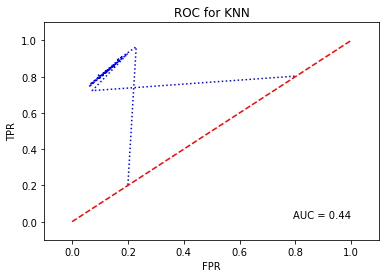

In [9]:
#plotting ROC

auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for KNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()
